In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import random
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import backend as K

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'


file = tf.keras.utils

with open(path+'/data/X_data_full.pkl','rb') as f:
  X_data=pickle.load(f)

raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'

metadata=pd.read_csv(path+'/data/metadata_final.csv')

X_data.head(5)

Mounted at /content/drive


,103SPREAD,LCEAPR01,XTIMVA01,PRMNTO01,MABMM301,PRCNTO01,STMNIS01,SLWHTO02,ODMNTO02,XTEXVA01,...,IRSTFR01,IRLTLT01,IR3TCD01,BSPRTE02,LREMTTTT,LRHU24TT,LRUNTTTT,BSCURT02,3MTBILL,10YT
date,,,,,,,,,,,,,,,,,,,,,
1973-01-01,1.05,0.004975,0.047149,0.007775,0.009922,0.013699,-0.006349,0.040962,0.014942,0.084607,...,0.61,0.10,0.38,2.569360,-0.2,-1.1,-0.3,0.3890,0.34,0.10
1973-02-01,1.04,0.002478,0.044624,0.015954,0.004679,0.020691,-0.006390,0.016314,0.023197,0.022962,...,0.64,0.18,0.53,-6.665425,0.4,0.7,0.1,1.1154,0.19,0.18
1973-03-01,0.62,0.004938,-0.012775,0.001725,0.001473,0.014144,0.006390,0.019215,0.022260,0.046380,...,0.51,0.07,0.71,0.992926,0.3,-0.5,-0.1,-0.1107,0.49,0.07
1973-04-01,0.41,0.004914,-0.009876,-0.001709,0.005382,-0.027771,0.006349,0.021154,-0.008716,0.033822,...,0.03,-0.04,0.26,-3.104780,-0.1,0.6,0.1,-0.4168,0.17,-0.04
1973-05-01,0.49,0.004890,0.062043,0.006343,0.008624,-0.010260,0.000000,0.014101,0.006697,0.012248,...,0.72,0.18,0.24,-13.030239,0.0,-0.3,-0.1,0.2500,0.10,0.18


In [3]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    if type(Xs)==pd.core.frame.DataFrame:
      for i in range(len(X) - time_steps + 1):
          v = X.iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(y.iloc[i + time_steps-1].values)
          Xs=np.array(Xs)
          ys=np.array(ys)

    else:
      for i in range(len(X) - time_steps + 1):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps-1])

    return np.array(Xs), np.array(ys)

In [4]:
# X=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
# y=np.array([10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
# len(X), len(y)


# X1=X[:-6]
# y1=y[:-6]
# X2=X[-6-2:]
# y2=y[-6-2:]

# print(len(X), len(X1), len(X2))

# print(create_dataset(X1,y1,3))
# print(create_dataset(X2,y2,3))

In [5]:
with open(path+'/model_test/df_selection.pkl', 'rb') as f:
  df_selection = pickle.load(f)

# model_name=df_selection.iloc[0].name[0]
# es=df_selection.iloc[0].name[1]
# print(model_name, es)  ## best model=clf_y_oecd_gru_24_b12_ep100_h30_d0.2_None /  es=True

model_name_list=[x for x, y in df_selection.iloc[:5].index]
es_list=[y for x, y in df_selection.iloc[:5].index]
print(model_name_list, es_list)

df_selection.head(5)

['clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None', 'clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None', 'clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01', 'clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None', 'clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None'] [True, True, True, False, True]


,,val,auc,recall_0,recall_1,recall_2,final_auc,final_recall_0,final_recall_1,final_recall_2,macro_recall
model,early_stopping,,,,,,,,,,
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None,True,1.0,0.634259,0.666667,0.602564,-100.0,0.870536,0.732143,1.00,-100.0,0.634615
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None,True,1.0,0.433333,0.518519,0.680702,-100.0,0.642857,0.803571,0.25,-100.0,0.599610
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01,True,1.0,0.585185,0.629630,0.563158,-100.0,0.886161,0.589286,1.00,-100.0,0.596394
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None,False,1.0,0.447917,0.666667,0.463333,-100.0,0.888393,0.732143,1.00,-100.0,0.565000
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None,True,1.0,0.464120,0.629630,0.476667,-100.0,0.863839,0.821429,0.75,-100.0,0.553148


In [6]:
nb_path = '/content/notebooks'
sys.path.insert(0,nb_path)
!pip install shap

tf.compat.v1.disable_v2_behavior()  ## input type err solved
from tensorflow.keras.models import load_model
import shap
from sklearn.metrics import confusion_matrix,classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.4 MB/s eta 0:00:00


Instructions for updating:
non-resource variables are not supported in the long term
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Train on 517 samples
Epoch 1/100
517/517 [==============================] - 1s 2ms/sample - loss: 0.5637 - auc: 0.8181 - accuracy: 0.0000e+00 - recall: 0.7292 - precision: 0.7292 - recall_0: 0.8703 - recall_1: 0.5446
Epoch 2/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.4975 - auc: 0.8743 - accuracy: 0.0000e+00 - recall: 0.7698 - precision: 0.7698 - recall_0: 0.8908 - recall_1: 0.6116
Epoch 3/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.4427 - auc: 0.9008 - accuracy: 0.0000e+00 - recall: 0.8221 - precision: 0.8221 - recall_0: 0.9044 - recall_1: 0.7143
Epoch 4/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.3824 - auc: 0.9289 - accuracy: 0.0000e+00 - recall: 0.8511 - precision: 0.8511 - recall_0: 0.9249 - recall_1: 0.7545
Epoch 5/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.3473 - auc: 0.9397 - accuracy: 0.0000e+00 - recall: 0.8859 - precision: 0.8859 - recall_0: 0.9113 - recall_1: 0.8527

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0 ranked model clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None shows
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        56
           1       0.25      1.00      0.40         4

    accuracy                           0.80        60
   macro avg       0.62      0.89      0.64        60
weighted avg       0.95      0.80      0.85        60



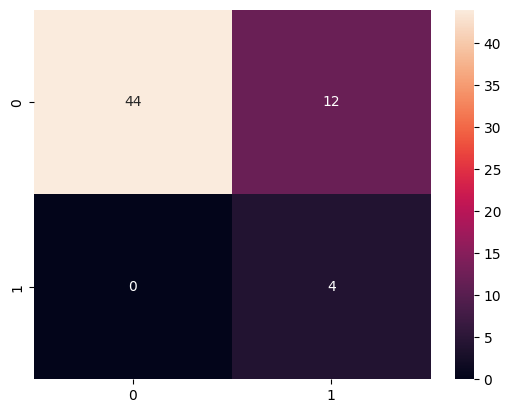

[0.4888942917188009, 0.8884722, 0.0, 0.8, 0.8, 0.78571427, 1.0]


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



Train on 523 samples
Epoch 1/100
523/523 [==============================] - 1s 1ms/sample - loss: 0.5344 - auc_2: 0.8096 - accuracy: 0.0000e+00 - recall_2: 0.7247 - precision_2: 0.7247 - recall_0: 0.8123 - recall_1: 0.6130
Epoch 2/100
523/523 [==============================] - 0s 556us/sample - loss: 0.4979 - auc_2: 0.8377 - accuracy: 0.0000e+00 - recall_2: 0.7514 - precision_2: 0.7514 - recall_0: 0.8532 - recall_1: 0.6217
Epoch 3/100
523/523 [==============================] - 0s 558us/sample - loss: 0.4602 - auc_2: 0.8655 - accuracy: 0.0000e+00 - recall_2: 0.7878 - precision_2: 0.7878 - recall_0: 0.8840 - recall_1: 0.6652
Epoch 4/100
523/523 [==============================] - 0s 582us/sample - loss: 0.4302 - auc_2: 0.8869 - accuracy: 0.0000e+00 - recall_2: 0.7916 - precision_2: 0.7916 - recall_0: 0.8567 - recall_1: 0.7087
Epoch 5/100
523/523 [==============================] - 0s 555us/sample - loss: 0.4042 - auc_2: 0.9027 - accuracy: 0.0000e+00 - recall_2: 0.8145 - precision_2: 0.8145

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1 ranked model clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None shows
              precision    recall  f1-score   support

           0       0.95      0.71      0.82        56
           1       0.11      0.50      0.18         4

    accuracy                           0.70        60
   macro avg       0.53      0.61      0.50        60
weighted avg       0.90      0.70      0.77        60



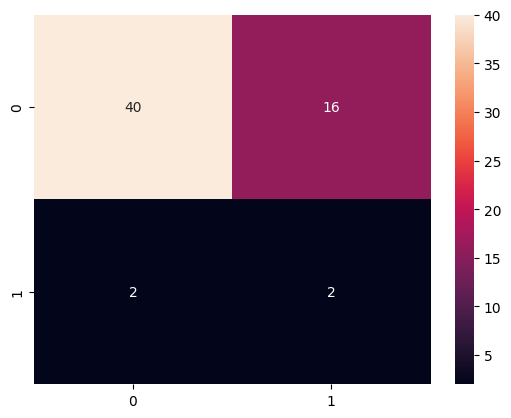

[0.4656722088654836, 0.8572222, 0.0, 0.7, 0.7, 0.71428573, 0.5]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 523 samples
Epoch 1/100
523/523 [==============================] - 1s 1ms/sample - loss: 1.1201 - auc_4: 0.8585 - accuracy: 0.0000e+00 - recall_4: 0.7648 - precision_4: 0.7648 - recall_0: 0.8976 - recall_1: 0.5957
Epoch 2/100
523/523 [==============================] - 0s 595us/sample - loss: 0.8891 - auc_4: 0.8800 - accuracy: 0.0000e+00 - recall_4: 0.7744 - precision_4: 0.7744 - recall_0: 0.9044 - recall_1: 0.6087
Epoch 3/100
523/523 [==============================] - 0s 628us/sample - loss: 0.7259 - auc_4: 0.8971 - accuracy: 0.0000e+00 - recall_4: 0.8107 - precision_4: 0.8107 - recall_0: 0.9010 - recall_1: 0.6957
Epoch 4/100
523/523 [==============================] - 0s 591us/sample - loss: 0.6263 - auc_4: 0.9116 - accuracy: 0.0000e+00 - recall_4: 0.8375 - precision_4: 0.8375 - recall_0: 0.8805 - recall_1: 0.7826
Epoch 5/100
523/523 [==============================] - 0s 602us/sample - loss: 0.5806 - auc_4: 0.9153 - accuracy: 0.0000e+00 - recall_4: 0.8298 - precision_4: 0.8298

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2 ranked model clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 shows
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        56
           1       0.15      1.00      0.27         4

    accuracy                           0.63        60
   macro avg       0.58      0.80      0.51        60
weighted avg       0.94      0.63      0.72        60



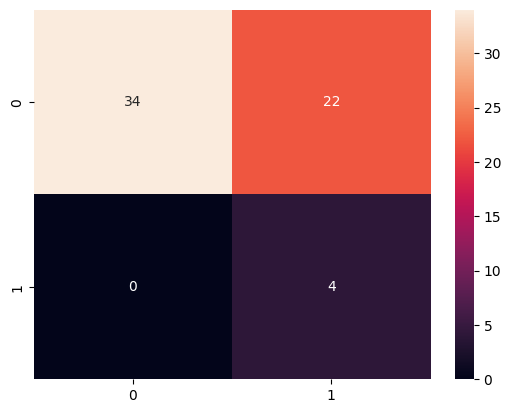

[1.1387610594431559, 0.7505555, 0.0, 0.6333333, 0.6333333, 0.60714287, 1.0]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 529 samples
Epoch 1/100
529/529 [==============================] - 1s 1ms/sample - loss: 0.0188 - auc_6: 0.9980 - accuracy: 0.0000e+00 - recall_6: 0.9962 - precision_6: 0.9962 - recall_0: 0.9966 - recall_1: 0.9958
Epoch 2/100
529/529 [==============================] - 0s 466us/sample - loss: 0.0091 - auc_6: 1.0000 - accuracy: 0.0000e+00 - recall_6: 0.9962 - precision_6: 0.9962 - recall_0: 1.0000 - recall_1: 0.9915
Epoch 3/100
529/529 [==============================] - 0s 501us/sample - loss: 0.0306 - auc_6: 0.9978 - accuracy: 0.0000e+00 - recall_6: 0.9943 - precision_6: 0.9943 - recall_0: 0.9932 - recall_1: 0.9958
Epoch 4/100
529/529 [==============================] - 0s 445us/sample - loss: 0.0109 - auc_6: 1.0000 - accuracy: 0.0000e+00 - recall_6: 0.9962 - precision_6: 0.9962 - recall_0: 0.9932 - recall_1: 1.0000
Epoch 5/100
529/529 [==============================] - 0s 456us/sample - loss: 0.0081 - auc_6: 1.0000 - accuracy: 0.0000e+00 - recall_6: 0.9962 - precision_6: 0.9962

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


3 ranked model clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None shows
              precision    recall  f1-score   support

           0       0.97      0.68      0.80        56
           1       0.14      0.75      0.24         4

    accuracy                           0.68        60
   macro avg       0.56      0.71      0.52        60
weighted avg       0.92      0.68      0.76        60



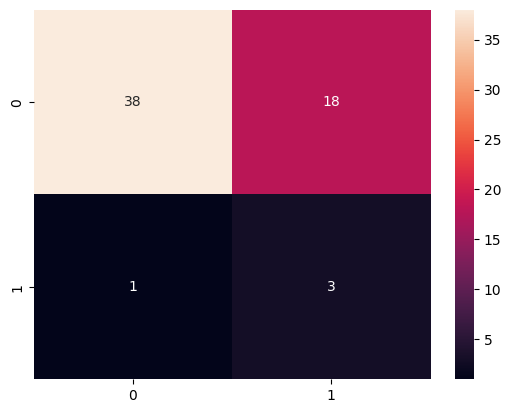

[1.823246959845225, 0.78138894, 0.0, 0.68333334, 0.68333334, 0.6785714, 0.75]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 529 samples
Epoch 1/100
529/529 [==============================] - 1s 2ms/sample - loss: 0.4437 - auc_8: 0.8766 - accuracy: 0.0000e+00 - recall_8: 0.7902 - precision_8: 0.7902 - recall_0: 0.8771 - recall_1: 0.6822
Epoch 2/100
529/529 [==============================] - 0s 886us/sample - loss: 0.3659 - auc_8: 0.9232 - accuracy: 0.0000e+00 - recall_8: 0.8374 - precision_8: 0.8374 - recall_0: 0.9010 - recall_1: 0.7585
Epoch 3/100
529/529 [==============================] - 0s 891us/sample - loss: 0.3106 - auc_8: 0.9454 - accuracy: 0.0000e+00 - recall_8: 0.8790 - precision_8: 0.8790 - recall_0: 0.9249 - recall_1: 0.8220
Epoch 4/100
529/529 [==============================] - 0s 908us/sample - loss: 0.2529 - auc_8: 0.9628 - accuracy: 0.0000e+00 - recall_8: 0.8998 - precision_8: 0.8998 - recall_0: 0.9113 - recall_1: 0.8856
Epoch 5/100
529/529 [==============================] - 0s 802us/sample - loss: 0.1913 - auc_8: 0.9779 - accuracy: 0.0000e+00 - recall_8: 0.9433 - precision_8: 0.9433

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4 ranked model clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None shows
              precision    recall  f1-score   support

           0       0.97      0.66      0.79        56
           1       0.14      0.75      0.23         4

    accuracy                           0.67        60
   macro avg       0.56      0.71      0.51        60
weighted avg       0.92      0.67      0.75        60



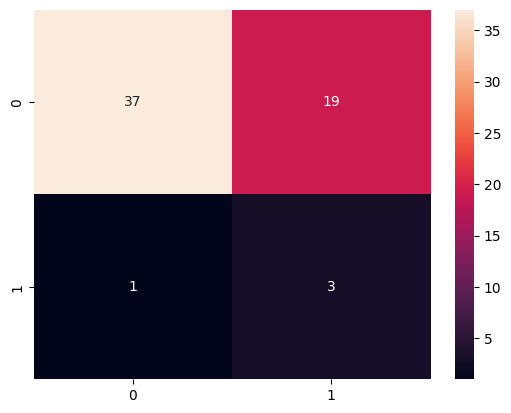

[0.515313466389974, 0.82305557, 0.0, 0.6666667, 0.6666667, 0.66071427, 0.75]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


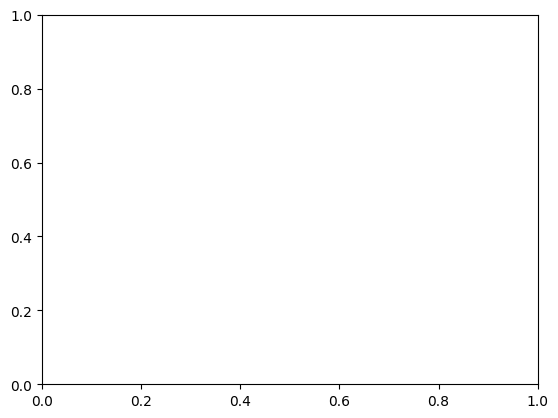

In [7]:
data=[]
shap_test=[]
shap_train=[]
scores_list=[]
explainer_list=[]
y_pred_prob_list=[]
y_pred_list=[]
y_test_list=[]
y_fit_prob_list=[]
y_fit_list=[]
y_train_list=[]

features_list=[]
test_year=5

for idx, (model_name, es) in enumerate(zip(model_name_list, es_list)):

  ytype= model_name.split('_')[2]  # options: nber, oecd, or agg
  model_type=model_name.split('_')[3]  # options: lstm, gru
  threshold=50

  if es==True:
    folder_path=path+'/model_test/change_test{}_{}_{}_es'.format(test_year, ytype, model_type)
  else:
    folder_path=path+'/model_test/change_test{}_{}_{}'.format(test_year, ytype, model_type)

  with open(path+'/data/X_data_full.pkl','rb') as f:
    X_data=pickle.load(f)

  y_type='y_{}'.format(ytype)
  n_splits=3
  test_year=5

  y=raw_df[y_type]
  y_data=y[-(threshold*12+6):-6]

  time_step=int(model_name.split('_')[4])
  batch_size=int(model_name.split('_')[5][1:])
  num_epochs=int(model_name.split('_')[6][2:])
  num_layer=int(model_name.split('_')[7][1:])
  dropout=float(model_name.split('_')[8][1:])
  method=model_name.split('_')[9]

  if method!='None':
    reg_factor=float(model_name.split('_')[10])
  else:
    reg_factor=0

  if y_type=='y_agg':
      num_classes=3
  else:
      num_classes=2

  # Also set the tf randomness to some fixed values like this if you need:
  np.random.seed(699)
  os.environ['PYTHONHASHSEED'] = '699'
  random.seed(699)
  tf.compat.v1.set_random_seed(699)
  tf.keras.utils.set_random_seed(699)

  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)


  ## whole train dataset
  X_train=X_data.iloc[:-test_year*12]
  y_train=y_data.iloc[:-test_year*12]
  X_test=X_data.iloc[-test_year*12-time_step+1:]
  y_test=y_data.iloc[-test_year*12-time_step+1:]

  ## standard scaling
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  ## make timestep
  trainx, trainy = create_dataset(X_train, y_train, time_step)
  testx, testy = create_dataset(X_test, y_test, time_step)
  trainy = to_categorical(trainy, num_classes=num_classes)
  testy = to_categorical(testy, num_classes=num_classes)

  data.append([trainx, trainy, testx, testy])

  ## calculate class weight
  if y_type!='y_agg':
    metrics=['AUC','Accuracy','Recall','Precision',
            Recall(class_id=0, name='recall_0'),
            Recall(class_id=1, name='recall_1')]

  else:
    metrics=['AUC','Accuracy','Recall','Precision',
            Recall(class_id=0, name='recall_0'),
            Recall(class_id=1, name='recall_1'),
            Recall(class_id=2, name='recall_2')]

  final_model=load_model(folder_path+'/{}.h5'.format(model_name), compile=False)
  final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

  if es==True:
    early_stop = EarlyStopping(monitor='recall_1', patience=5, verbose=1,restore_best_weights=True)
    history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
  else:
    history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size)

  scores=final_model.evaluate(testx, testy, verbose=0)
  y_pred_prob=final_model.predict(testx)
  y_pred=final_model.predict(testx).argmax(axis=1)
  y_test=testy.argmax(axis=1)

  y_fit_prob=final_model.predict(trainx)
  y_fit=final_model.predict(trainx).argmax(axis=1)
  y_train=trainy.argmax(axis=1)

  scores_list.append(scores)
  y_pred_prob_list.append(y_pred_prob)
  y_pred_list.append(y_pred)
  y_test_list.append(y_test)

  y_fit_prob_list.append(y_fit_prob)
  y_fit_list.append(y_fit)
  y_train_list.append(y_train)

  # Showing percentage of data represented in each quadrant
  # sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
  #             fmt='.2%', cmap='Blues')

  print('{} ranked model {} shows'.format(idx, model_name))
  print(classification_report(y_test, y_pred))
  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix, annot=True)
  plt.show()
  plt.cla()

  print(scores)

  ## generate shap explainer and calculate shap values
  explainer=shap.DeepExplainer(final_model, trainx)
  values_test=explainer.shap_values(np.array(testx))
  values_train=explainer.shap_values(np.array(trainx))

  final_model.save(path+'/model_test/{}_top{}_alltrained.h5'.format(model_name, idx))
  explainer_list.append(explainer)
  shap_test.append(values_test)
  shap_train.append(values_train)

  selected_features=list(X_data.columns)

  features_list.append(selected_features)

In [8]:
analysis_dict={'model_name':model_name_list, 'early_stopping':es_list, 'data':data,
               'shap_test':shap_test, 'shap_train':shap_train, 'scores':scores_list,
               'y_pred_prob':y_pred_prob_list, 'y_pred':y_pred_list,  #'explainer':explainer_list,
               'y_test':y_test_list, 'y_fit_prob':y_fit_prob_list, 'y_fit':y_fit_list,
               'y_train':y_train_list, 'selected_features':features_list}

with open(path+'/model_test/analysis_dict.pkl', 'wb') as f:
  pickle.dump(analysis_dict, f)

In [9]:
# for idx, explainer in enumerate(explainer_list):
#   with open(path+'/model_test/explainer_{}.save'.format(idx), "wb") as f:
#     explainer.save(f)

In [10]:
with open(path+'/model_test/analysis_dict.pkl', 'rb') as f:
  analysis_dict=pickle.load(f)

data=analysis_dict['data']
shap_test=analysis_dict['shap_test']
shap_train=analysis_dict['shap_train']
scores_list=analysis_dict['scores']
y_pred_prob_list=analysis_dict['y_pred_prob']
y_pred_list=analysis_dict['y_pred']
y_test_list=analysis_dict['y_test']
y_fit_prob_list=analysis_dict['y_fit_prob']
y_fit_list=analysis_dict['y_fit']
y_train_list=analysis_dict['y_train']
features_list=analysis_dict['selected_features']

In [11]:
idx=0

y_pred_prob=y_pred_prob_list[idx]
y_pred=y_pred_list[idx]
y_test=y_test_list[idx]

y_fit_prob=y_fit_prob_list[idx]
y_fit=y_fit_list[idx]
y_train=y_train_list[idx]

len(y_test), len(y_pred), len(y_pred_prob), len(y_train), len(y_fit), len(y_fit_prob)

(60, 60, 60, 517, 517, 517)

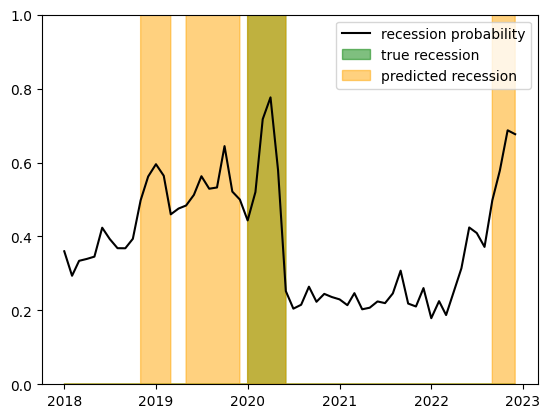

In [12]:
## ****** assign label here! ***********//
idx=0 ## 1st rank=idx 0
test_year=5
##############################################################
y_pred_prob=y_pred_prob_list[idx]
y_pred=y_pred_list[idx]
y_test=y_test_list[idx]

plt.plot(X_data.index[-test_year*12:], y_pred_prob[:,1], color='black', label='recession probability')
plt.fill_between(X_data.index[-test_year*12:],0,y_test*1000, color='green', alpha=0.5, label='true recession')
plt.fill_between(X_data.index[-test_year*12:], 0, y_pred*1000, color='orange', alpha=0.5, label='predicted recession')
plt.ylim([0,1])
plt.legend()

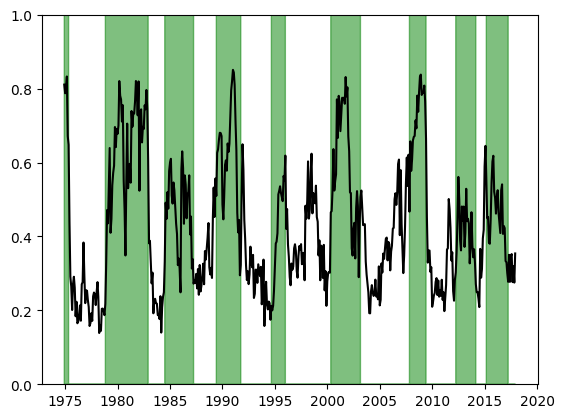

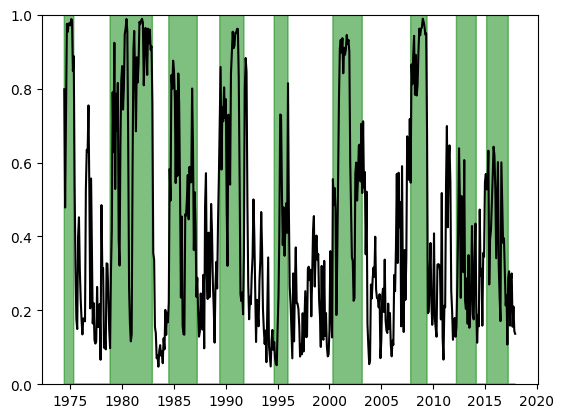

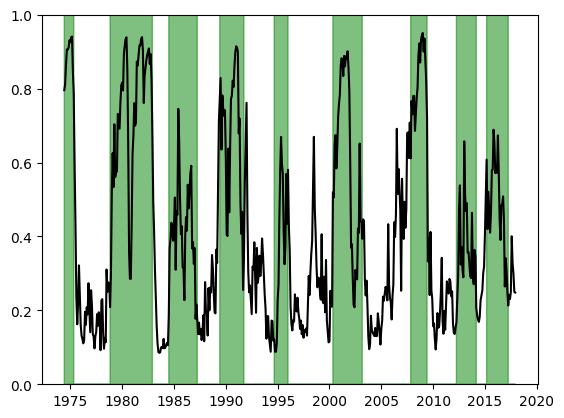

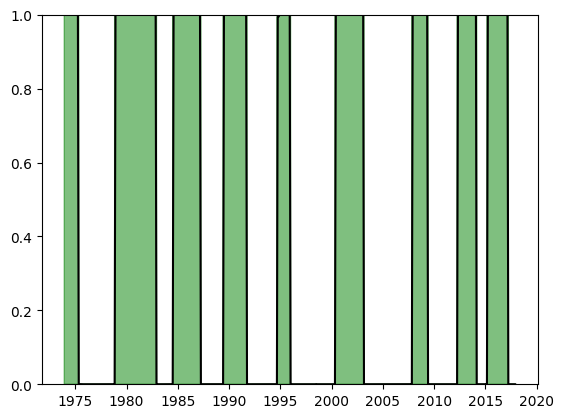

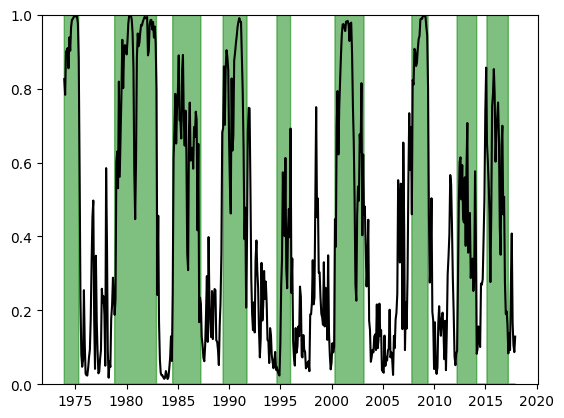

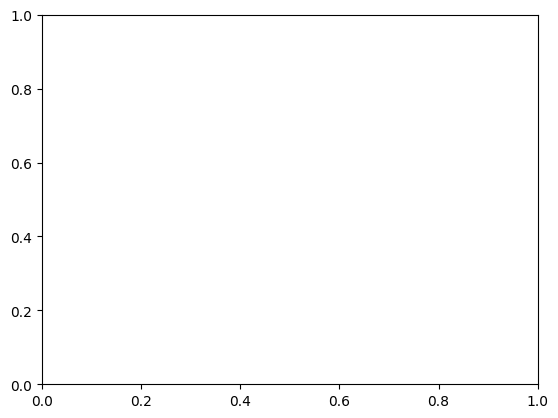

In [13]:
## ****** assign label here! ***********//
#idx=0 ## 1st rank=idx 0
test_year=5
##############################################################
for idx in range(5):

  y_pred_prob=y_pred_prob_list[idx]
  y_pred=y_pred_list[idx]
  y_test=y_test_list[idx]

  y_fit_prob=y_fit_prob_list[idx]
  y_fit=y_fit_list[idx]
  y_train=y_train_list[idx]
  model_name=model_name_list[idx]

  time_step=int(model_name.split('_')[4])

  plt.plot(X_data.index[time_step-1:-test_year*12], y_fit_prob[:,1], color='black', label='recession probability')
  plt.fill_between(X_data.index[time_step-1:-test_year*12],0,y_train*1000, color='green', alpha=0.5, label='true recession')
  #plt.fill_between(X_data.index[time_step-1:-test_year*12], 0, y_fit*1000, color='orange', alpha=0.5, label='trained recession')
  plt.ylim([0,1])
  #plt.legend()

  plt.show()
  plt.cla()

In [14]:
len(y_train)

529

Top 1 ranked model


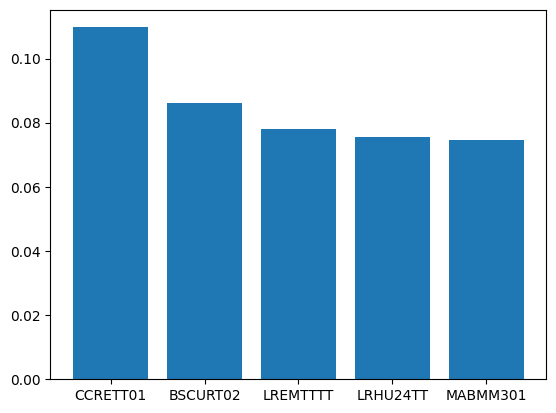

['Currency Conversions Real effective exchange rates Overall Economy CPI', 'Business tendency surveys (manufacturing) Capacity utilisation Rate of capacity utilisation National indicator', 'Labour Force Survey - quarterly rates Employment rate Aged 15 and over All persons', 'Labour Force Survey - quarterly rates Harmonised unemployment - monthly rates Aged 15-24 All persons', 'Monetary aggregates and their components Broad money and components M3 M3']
Top 2 ranked model


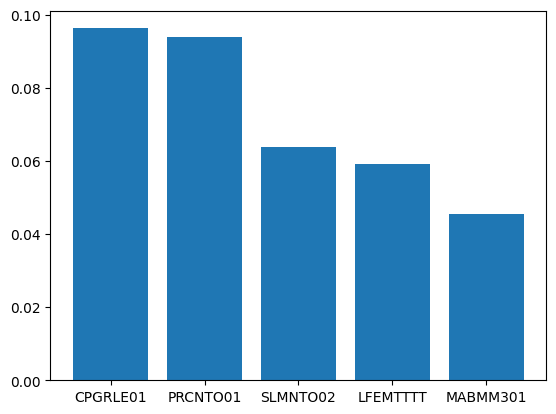

['Consumer Price Index OECD Groups All items non-food non-energy Total', 'Production Construction Total construction Total', 'Sales Manufacturing Total manufacturing Value', 'Labour Force Survey - quarterly levels Employed population Aged 15 and over All persons', 'Monetary aggregates and their components Broad money and components M3 M3']
Top 3 ranked model


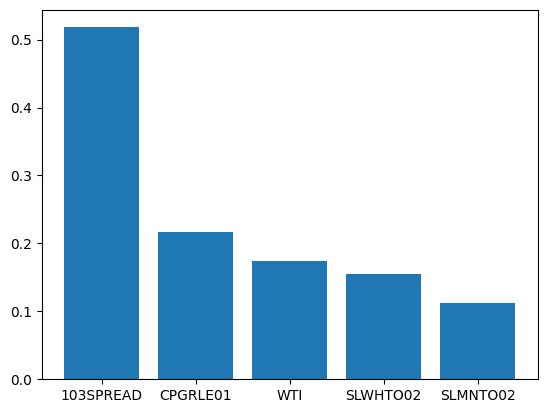

['10YT-3MTBILL', 'Consumer Price Index OECD Groups All items non-food non-energy Total', 'WTI spot price', 'Sales Wholesale trade Total wholesale trade Value', 'Sales Manufacturing Total manufacturing Value']
Top 4 ranked model


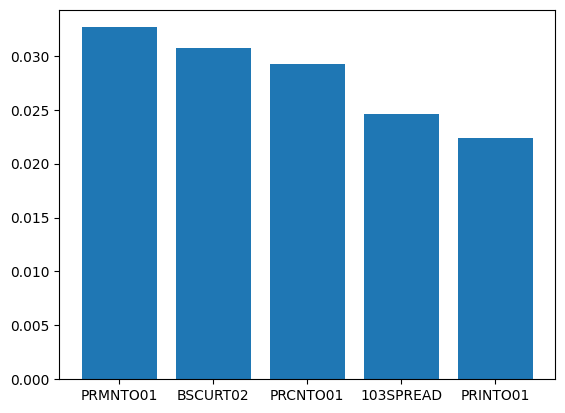

['Production Manufacturing Total manufacturing Total manufacturing', 'Business tendency surveys (manufacturing) Capacity utilisation Rate of capacity utilisation National indicator', 'Production Construction Total construction Total', '10YT-3MTBILL', 'Production Industry Total industry Total industry excluding construction']
Top 5 ranked model


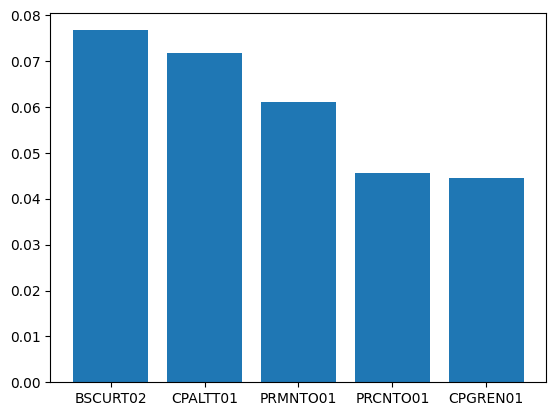

['Business tendency surveys (manufacturing) Capacity utilisation Rate of capacity utilisation National indicator', 'Consumer Price Index All items Total Total', 'Production Manufacturing Total manufacturing Total manufacturing', 'Production Construction Total construction Total', 'Consumer Price Index OECD Groups Energy (Fuel, electricity & gasoline) Total']


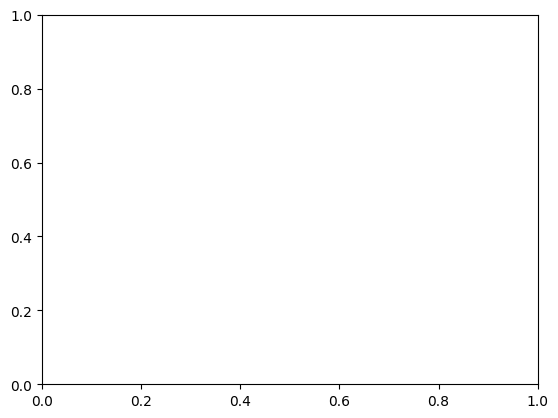

In [15]:
## feature importance
## ****** assign label here! ***********//
label=1
version='train' ## 'train' or 'test'
idx=0 ## 1st rank=idx 0
##############################################################

for idx in [0,1,2,3,4]:

  print('Top {} ranked model'.format(idx+1))
  selected_features=features_list[idx]
  values_train=shap_train[idx]
  values_test=shap_test[idx]
  trainx=data[idx][0]
  testx=data[idx][2]

  if version=='train':
      values=values_train
      x=trainx
  else:
      values=values_test
      x=testx

  ft_imp=abs(np.sum(values, axis=2)[label]).mean(0)
  df=pd.DataFrame({'feature':selected_features, 'ft_imp':ft_imp}).sort_values('ft_imp', ascending=False)[:5]
  plt.bar(df.feature, df.ft_imp)
  plt.show()
  plt.cla()
  print([metadata[metadata.SUBJECT==x]['Name'].values[0] for x in df.feature])


##['Interest Rates Long-term government bond yields 10-year Main (including benchmark)',
#  'Monetary aggregates and their components Broad money and components M3 M3',
#  'Labour Force Survey - quarterly levels Employed population Aged 15 and over All persons',
#  'Consumer Price Index OECD Groups All items non-food non-energy Total',
#  'Real personal income excluding current transfer receipts']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


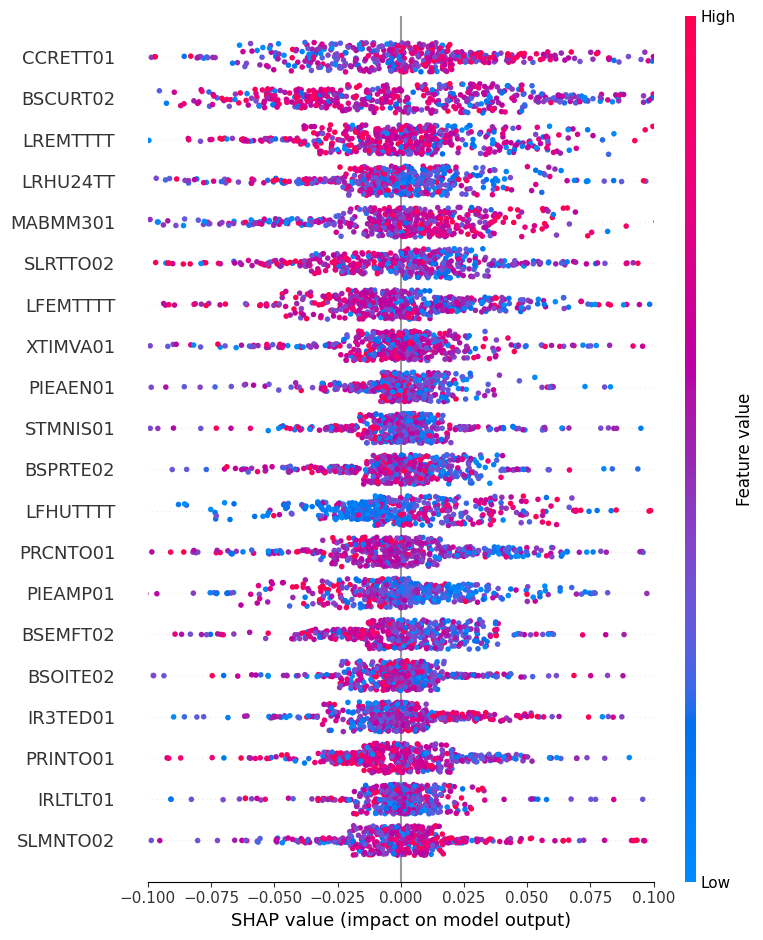

In [16]:
## ****** assign here! ***********//
label=1
version='train' ## 'train' or 'test'
idx=0 ## 1st rank=idx 0
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.summary_plot(np.sum(values, axis=2)[label], np.mean(x, axis=1), selected_features, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.1, 0.1)
plt.show()

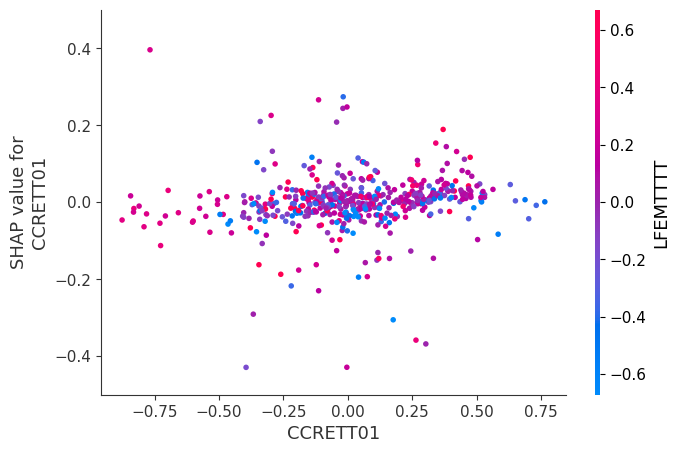

In [17]:
## ****** assign here! ***********//
label=1
variable='CCRETT01'
version='train' ## 'train' or 'test'
idx=0 ## 1st rank=idx 0
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]

var_idx=selected_features.index(variable)

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.dependence_plot(var_idx, np.sum(values, axis=2)[label], np.mean(x, axis=1), feature_names=selected_features, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_ylim(-0.5, 0.5)
plt.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


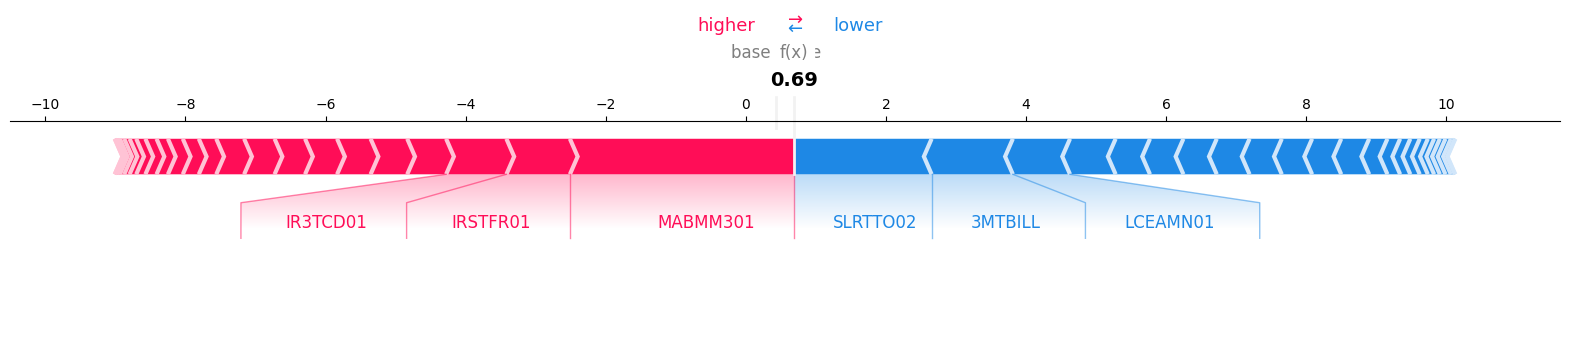

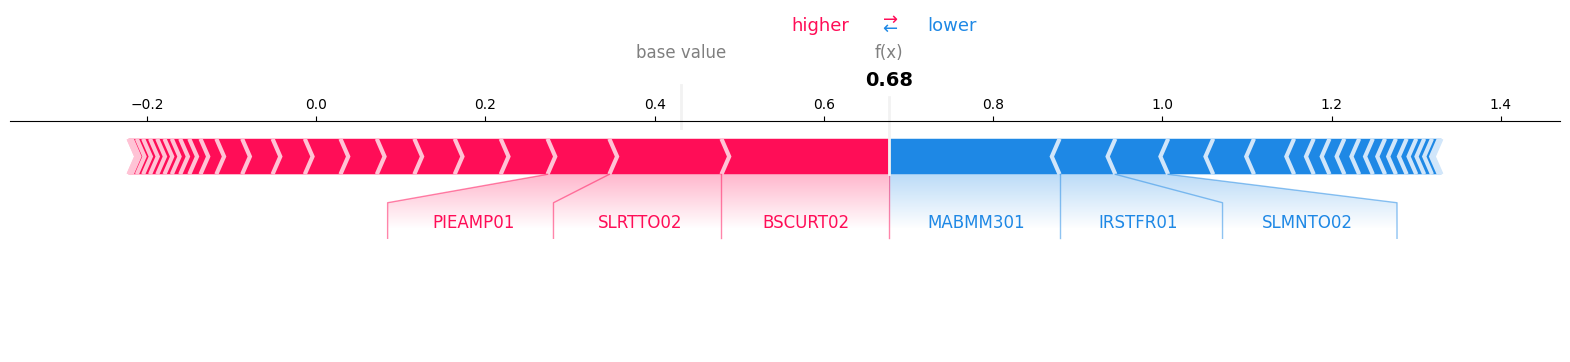

In [18]:
## ****** assign here! ***********//
label=1
version='test' ## 'train' or 'test'
t_list=[-2, -1]
idx=0 ## 1st rank=idx 0
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
#explainer=explainer_list[idx]
model_name=model_name_list[idx]
final_model=load_model(path+'/model_test/{}_top{}_alltrained.h5'.format(model_name, idx))
explainer=shap.DeepExplainer(final_model, trainx)

if version=='train':
    values=values_train
else:
    values=values_test

for t in t_list:
    value_ft_t=np.sum(values[label][t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[label], value_ft_t, selected_features, matplotlib=True)

In [19]:
true_label=0
false_label=1
idx=0 ## 1st rank=idx 0
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]
y_pred=y_pred_list[idx]
y_test=y_test_list[idx]
#explainer=explainer_list[idx]
final_model=load_model(path+'/model_test/{}_top{}_alltrained.h5'.format(model_name, idx))
explainer=shap.DeepExplainer(final_model, trainx)

## calculate error time period list
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten() ## 1인데, 0으로 예측한 t지점들

## for each error time period, draw force_plot in terms of features
#value_ft=np.sum(values_test[label][t], axis=0)

for err_t in err_idxs:
    value_ft=np.sum(values_test[true_label][err_t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ft, selected_features, matplotlib=True)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
true_label=0
false_label=1
idx=0 ## 1st rank=idx 0
##############################################################

time_step=int(model_name_list[idx].split('_')[4])
selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]
y_pred=y_pred_list[idx]
y_test=y_test_list[idx]
#explainer=explainer_list[idx]
final_model=load_model(path+'/model_test/{}_top{}_alltrained.h5'.format(model_name, idx))
explainer=shap.DeepExplainer(final_model, trainx)


## calculate error time period list
ts_list=list(range(time_step))
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten()

## for each error time period, draw force_plot in terms of time steps
for err_t in err_idxs:
    value_ts=np.sum(values_test[true_label][err_t], axis=1)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ts, ts_list, matplotlib=True)

Output hidden; open in https://colab.research.google.com to view.